In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
#save training saleprice beforehand
train_sp = train[['SalePrice']]
#save idtests for kaggle csv creation
id_test = test[['Id']]

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Exploration and Processing

Note: Major exploration in supplemental notebook to preserve brevity of this main notebook.

<AxesSubplot:xlabel='LotShape', ylabel='Count'>

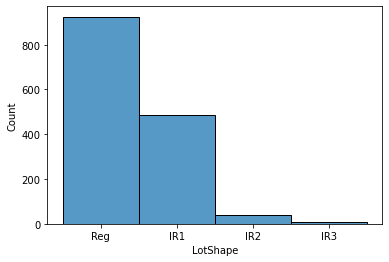

In [4]:
sns.histplot(data=train['LotShape'], element='bars')

<AxesSubplot:xlabel='LotArea', ylabel='Count'>

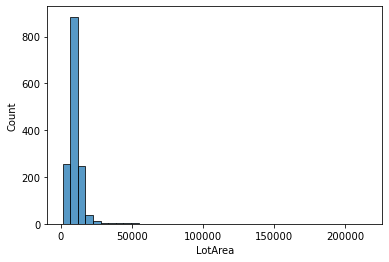

In [5]:
sns.histplot(data=train['LotArea'], element='bars', bins=40)

In [6]:
cols_to_drop = ['Street', 'Utilities', 'Condition2', 'LowQualFinSF', 'Functional', 'Fence', 'MiscVal'] #based on EDA

In [7]:
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
#look for columns that have a lot of missing values (fraction of missing values)
train.count()/train.shape[0]

Id               1.000000
MSSubClass       1.000000
MSZoning         1.000000
LotFrontage      0.822603
LotArea          1.000000
                   ...   
MoSold           1.000000
YrSold           1.000000
SaleType         1.000000
SaleCondition    1.000000
SalePrice        1.000000
Length: 74, dtype: float64

<AxesSubplot:>

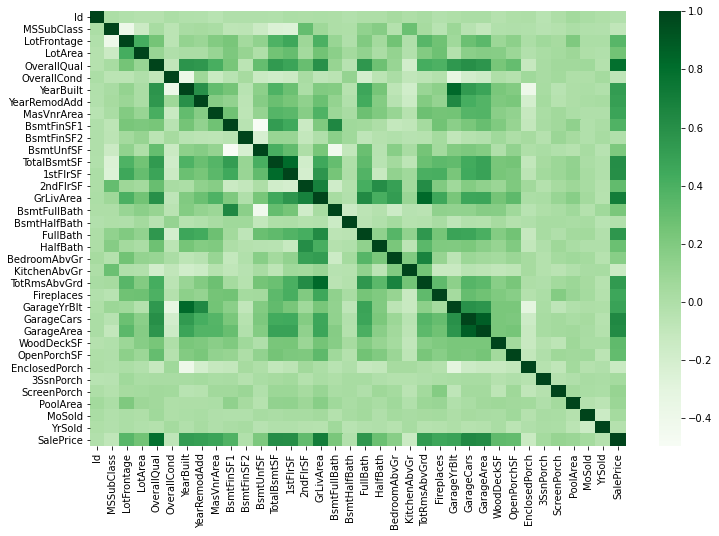

In [9]:
#plot corr matrix to get a visual summary
corr_matrix = train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='Greens')

In [10]:
#calculate correlation of numerical features with target variable
#potentially filter out features that have a very low correlation (<10%)
target_var = "SalePrice"
corr_matrix[target_var].apply(lambda x: abs(x)).sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
Id               0.021917
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

In [11]:
#drop cols with corr vals less than 10% 
train.drop(['PoolArea', 'MSSubClass', 'OverallCond', 'MoSold', '3SsnPorch', 'YrSold', 'Id'], axis=1, inplace=True)
test.drop(['PoolArea', 'MSSubClass', 'OverallCond', 'MoSold', '3SsnPorch', 'YrSold', 'Id'], axis=1, inplace=True)

In [12]:
#certain columns have NAN as a cateogry, i.e. NAN in features like BsmtQual means there is no basement in that 
#house. according to the documentation, in these special cases, NAN indicates a value instead of indicating 
#missing data. so i fill in NAN values in the respective columns for the train and test data with unique 
#identifier '$$'

train.update(train[['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                    'GarageFinish', 'GarageType', 'GarageQual', 'Electrical', 'FireplaceQu', 'PoolQC',
                    'GarageCond']].fillna(value='$$'))
test.update(test[['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                    'GarageFinish', 'GarageType', 'GarageQual', 'Electrical', 'FireplaceQu', 'PoolQC',
                    'GarageCond']].fillna(value='$$'))

In [13]:
#find and delete all columns with more than 70% missing values assuming that features with more than 70% missing 
#values (or less than 30% non-null values) are less useful
for col in train:
    if train[col].count()/train.shape[0] < 0.3:
        print(col)
        del(train[col])
        del(test[col])

MiscFeature


In [14]:
#fill missing data
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median()) #numerical => use median
train['MasVnrArea'] = train['MasVnrArea'].fillna(0) #numerical but missing value often means no masonry veneer as it is related to MasVnrType
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0) #the house has no garage
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0]) #use mode to fill in categorical value
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].median()) #numerical => use median
test['MasVnrArea'] = test['MasVnrArea'].fillna(0) #numerical but missing value often means no masonry veneer as it is related to MasVnrType
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0) #the house has no garage
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0]) #use mode to fill in categorical value

In [15]:
#handle any other missing data that might have been missed in the steps above
def fill_missing_data(df):
    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = df.select_dtypes(exclude=np.number).columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])    
    return df

In [16]:
train = fill_missing_data(train)
test = fill_missing_data(test)

In [17]:
#rearrange the columns to have numerical/continuous features first and categorical features afterwards
cat = []
cont = []
for col in train:
    if train[col].dtypes == 'object' or col == 'MSSubClass':
        cat.append(col)
    elif col != 'SalePrice' and col != 'Id':
        cont.append(col)
        
train_cat = train[cat]
train_cont = train[cont]
test_cat = test[cat]
test_cont = test[cont]
train = pd.concat([train_cont, train_cat], axis=1)
test = pd.concat([test_cont, test_cat], axis=1)

In [18]:
#combine the datasets before performing one hot encoding
combined = pd.concat([train, test], axis=0, sort=False)

In [19]:
combined

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,SaleType,SaleCondition
0,65.0,8450,7,2003,2003,196.0,706.0,0.0,150.0,856.0,...,Gd,$$,Attchd,RFn,TA,TA,Y,$$,WD,Normal
1,80.0,9600,6,1976,1976,0.0,978.0,0.0,284.0,1262.0,...,TA,TA,Attchd,RFn,TA,TA,Y,$$,WD,Normal
2,68.0,11250,7,2001,2002,162.0,486.0,0.0,434.0,920.0,...,Gd,TA,Attchd,RFn,TA,TA,Y,$$,WD,Normal
3,60.0,9550,7,1915,1970,0.0,216.0,0.0,540.0,756.0,...,Gd,Gd,Detchd,Unf,TA,TA,Y,$$,WD,Abnorml
4,84.0,14260,8,2000,2000,350.0,655.0,0.0,490.0,1145.0,...,Gd,TA,Attchd,RFn,TA,TA,Y,$$,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,1936,4,1970,1970,0.0,0.0,0.0,546.0,546.0,...,TA,$$,$$,$$,$$,$$,Y,$$,WD,Normal
1455,21.0,1894,4,1970,1970,0.0,252.0,0.0,294.0,546.0,...,TA,$$,CarPort,Unf,TA,TA,Y,$$,WD,Abnorml
1456,160.0,20000,5,1960,1996,0.0,1224.0,0.0,0.0,1224.0,...,TA,TA,Detchd,Unf,TA,TA,Y,$$,WD,Abnorml
1457,62.0,10441,5,1992,1992,0.0,337.0,0.0,575.0,912.0,...,TA,$$,$$,$$,$$,$$,Y,$$,WD,Normal


In [20]:
#perform one hot encoding on all categorical features
combined = pd.get_dummies(combined, prefix=cat, columns=cat, drop_first=True)

In [21]:
combined

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,2003,2003,196.0,706.0,0.0,150.0,856.0,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,6,1976,1976,0.0,978.0,0.0,284.0,1262.0,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,7,2001,2002,162.0,486.0,0.0,434.0,920.0,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,7,1915,1970,0.0,216.0,0.0,540.0,756.0,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,8,2000,2000,350.0,655.0,0.0,490.0,1145.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,1936,4,1970,1970,0.0,0.0,0.0,546.0,546.0,...,0,0,0,0,1,0,0,0,1,0
1455,21.0,1894,4,1970,1970,0.0,252.0,0.0,294.0,546.0,...,0,0,0,0,1,0,0,0,0,0
1456,160.0,20000,5,1960,1996,0.0,1224.0,0.0,0.0,1224.0,...,0,0,0,0,1,0,0,0,0,0
1457,62.0,10441,5,1992,1992,0.0,337.0,0.0,575.0,912.0,...,0,0,0,0,1,0,0,0,1,0


In [22]:
df_cols = combined.columns.tolist()

In [23]:
#break datasets into train and test dataframes
df_train = combined.iloc[:1460,:]
df_train =df_train.loc[:,~df_train.columns.duplicated()]

df_test = combined.iloc[1460:,:]
df_test =df_test.loc[:,~df_test.columns.duplicated()]

<AxesSubplot:xlabel='LotShape', ylabel='Count'>

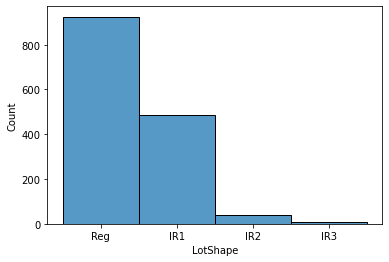

In [24]:
sns.histplot(data=train['LotShape'], element='bars')

There should be 4 histrograms (or one histogram broken into 4 parts) for the OHE version of the LotShape feature.  I dropped one of the columns while performing OHE (namely IR1) to avoid the linear dependence error. There is redundancy in keeping k dummy variables to represent k categories of a categorical variable because the combination of the other (k-1) columns will be uniquely representing the redundant column. 

Therefore, for demonstration purposes for this historgram, I am specifically one-hot encoding the LotShape feature without dropping the first OHE column. The actual OHE is performed on all categorical variables earlier in the notebook. 

In [25]:
train_lotshape = train['LotShape']
lotshape = pd.get_dummies(train_lotshape, prefix='LotShape', columns='LotShape', drop_first=False)

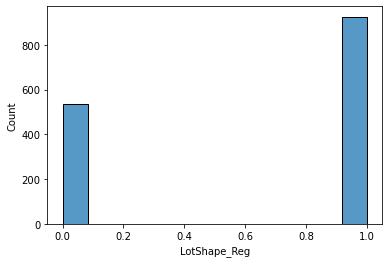

In [26]:
h0 = sns.histplot(data=lotshape['LotShape_Reg'], element='bars')

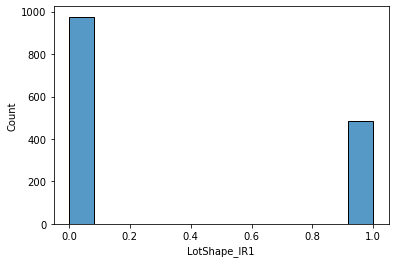

In [27]:
h1 = sns.histplot(data=lotshape['LotShape_IR1'], element='bars')

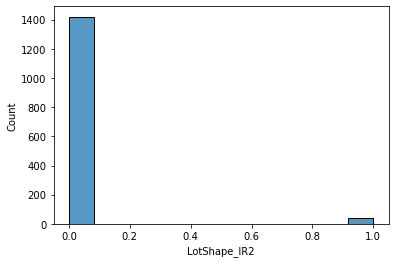

In [28]:
h2 = sns.histplot(data=lotshape['LotShape_IR2'], element='bars')

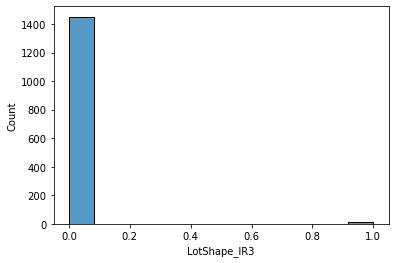

In [29]:
h3 = sns.histplot(data=df_train['LotShape_IR3'], element='bars')

<AxesSubplot:ylabel='Count'>

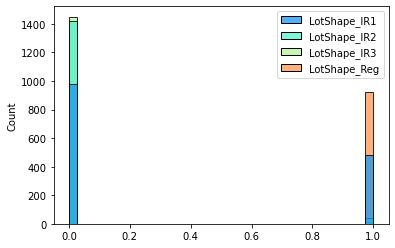

In [30]:
sns.histplot(data=lotshape, element='bars', palette='rainbow')

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_arr = scaler.fit_transform(df_train)
test_arr = scaler.transform(df_test)

In [32]:
train_final = pd.DataFrame(train_arr, columns=df_cols)
test_final = pd.DataFrame(test_arr, columns=df_cols)

In [33]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [34]:
def scale_back(train_og, to_scale):
    max_value = train_og.max()
    min_value = train_og.min()
    result = min_value + (to_scale * (max_value - min_value))
    return result

In [35]:
train_final

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.150685,0.033420,0.666667,0.949275,0.883333,0.122500,0.125089,0.000000,0.064212,0.140098,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.202055,0.038795,0.555556,0.753623,0.433333,0.000000,0.173281,0.000000,0.121575,0.206547,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.160959,0.046507,0.666667,0.934783,0.866667,0.101250,0.086109,0.000000,0.185788,0.150573,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.133562,0.038561,0.666667,0.311594,0.333333,0.000000,0.038271,0.000000,0.231164,0.123732,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.215753,0.060576,0.777778,0.927536,0.833333,0.218750,0.116052,0.000000,0.209760,0.187398,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.140411,0.030929,0.555556,0.920290,0.833333,0.000000,0.000000,0.000000,0.407962,0.155974,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1456,0.219178,0.055505,0.555556,0.768116,0.633333,0.074375,0.139972,0.110583,0.252140,0.252373,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1457,0.154110,0.036187,0.666667,0.500000,0.933333,0.000000,0.048724,0.000000,0.375428,0.188543,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1458,0.160959,0.039342,0.444444,0.565217,0.766667,0.000000,0.008682,0.698100,0.000000,0.176432,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [36]:
test_final

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.202055,0.048246,0.444444,0.644928,0.183333,0.00000,0.082920,0.097693,0.115582,0.144354,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.205479,0.060609,0.555556,0.623188,0.133333,0.06750,0.163536,0.000000,0.173801,0.217512,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.181507,0.058566,0.444444,0.905797,0.800000,0.00000,0.140149,0.000000,0.058647,0.151882,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.195205,0.040562,0.555556,0.913043,0.800000,0.01250,0.106662,0.000000,0.138699,0.151555,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.075342,0.017318,0.777778,0.869565,0.700000,0.00000,0.046598,0.000000,0.435360,0.209493,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.000000,0.002973,0.333333,0.710145,0.333333,0.00000,0.000000,0.000000,0.233733,0.089362,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1455,0.000000,0.002776,0.333333,0.710145,0.333333,0.00000,0.044649,0.000000,0.125856,0.089362,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,0.476027,0.087406,0.444444,0.637681,0.766667,0.00000,0.216867,0.000000,0.000000,0.200327,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,0.140411,0.042726,0.444444,0.869565,0.700000,0.00000,0.059709,0.000000,0.246147,0.149264,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [37]:
#drop a column if it has all the same values (Sanity check)
#drop columns with all NAN values -- this is to ensure that train and test dfs don't have any columns with all 
#null values
nunique_train = train_final.nunique()
cols_to_drop = nunique_train[nunique_train == 1].index
cols_to_drop_2 = train_final.columns[train_final.isnull().any()]
cols_to_drop_3 = test_final.columns[test_final.isnull().any()]
train_final.drop(cols_to_drop, axis=1, inplace=True)
train_final.drop(cols_to_drop_2, axis=1, inplace=True)
train_final.drop(cols_to_drop_3, axis=1, inplace=True)

In [38]:
test_final.drop(cols_to_drop, axis=1, inplace=True)
test_final.drop(cols_to_drop_2, axis=1, inplace=True)
test_final.drop(cols_to_drop_3, axis=1, inplace=True)

In [39]:
columns = df_test.columns.values.tolist()

In [40]:
train_final.shape

(1460, 230)

In [41]:
test_final.shape

(1459, 230)

In [42]:
train_final.columns[test_final.isnull().any()]

Index([], dtype='object')

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train_i, X_val_i, y_train, y_val = train_test_split(train_final, 
                                                    normalize(train_sp).iloc[:,0], test_size=0.30, 
                                                    random_state=101)

In [45]:
train_df = pd.DataFrame(X_train_i, columns=train_final.columns)
val_df = pd.DataFrame(X_val_i, columns=train_final.columns)
test_df = test_final

In [46]:
train_df_num = train_df[cont]
val_df_num = val_df[cont]
test_df_num = test_df[cont]
train_df_cat = train_df.drop(cont, axis=1)
val_df_cat = val_df.drop(cont, axis=1)
test_df_cat = test_df.drop(cont, axis=1)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(train_df_num)
X_val_pca = pca.transform(val_df_num)
X_test_pca = pca.transform(test_df_num)

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
fvalue_selector = SelectKBest(f_regression, k=75)  #select features with best ANOVA F-Values
X_train_anova = fvalue_selector.fit_transform(train_df_cat, y_train)
X_val_anova = fvalue_selector.transform(val_df_cat)
X_test_anova = fvalue_selector.transform(test_df_cat)

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [49]:
X_train = np.concatenate((X_train_pca, X_train_anova), 1)
X_val = np.concatenate((X_val_pca, X_val_anova), 1)
X_test = np.concatenate((X_test_pca, X_test_anova), 1)

In [50]:
X_train = np.append(X_train,np.ones([len(X_train),1]),1)
X_val = np.append(X_val,np.ones([len(X_val),1]),1)

In [51]:
X_test = np.append(X_test,np.ones([len(X_test),1]),1)

# Ordinary Least Squares

In [52]:
#ordinary least squares

theta_best = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
theta_best_df = pd.DataFrame(data=theta_best)
#theta_best_df

Text(0, 0.5, 'y_val_pred')

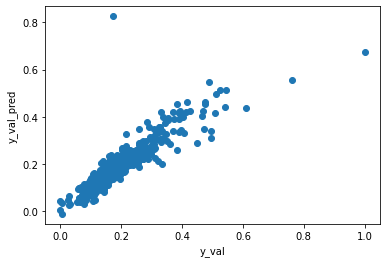

In [53]:
y_val_predict = X_val.dot(theta_best)
plt.scatter(y_val, y_val_predict)
plt.xlabel('y_val')
plt.ylabel('y_val_pred')

In [54]:
def mean_squared_error(theta, X, y):
    """The cost function, J, describing the goodness of fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return 0.5*np.mean((y-(X.dot(theta)))**2)

In [55]:
mse = mean_squared_error(theta_best, X_val, y_val)
print(mse)

0.001306245635133383


In [56]:
from sklearn.metrics import r2_score
r2 = r2_score(y_val, y_val_predict)
r2

0.7847246606177815

In [57]:
rmsle = np.sqrt(np.mean((np.log(y_val + 1) - np.log(y_val_predict + 1))**2))
rmsle

0.03698816607004099

# Re-Train using entire Training set and predict using Test set (for Kaggle submission)

In [58]:
train_kaggle_num = train_final[cont]
test_kaggle_num = test_final[cont]
y_train_kaggle = normalize(train_sp).to_numpy()
train_kaggle_cat = train_final.drop(cont, axis=1)
test_kaggle_cat = test_final.drop(cont, axis=1)

In [59]:
y_train_kaggle

array([[0.24107763],
       [0.20358284],
       [0.26190807],
       ...,
       [0.321622  ],
       [0.14890293],
       [0.15636717]])

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_train_kaggle_pca = pca.fit_transform(train_kaggle_num)
X_test_kaggle_pca = pca.transform(test_kaggle_num)

In [61]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
fvalue_selector = SelectKBest(f_regression, k=75)  #select features with best ANOVA F-Values
X_train_kaggle_anova = fvalue_selector.fit_transform(train_kaggle_cat, y_train_kaggle)
X_test_kaggle_anova = fvalue_selector.transform(test_kaggle_cat)

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [62]:
X_train_kaggle = np.concatenate((X_train_kaggle_pca, X_train_kaggle_anova), 1)
X_test_kaggle = np.concatenate((X_test_kaggle_pca, X_test_kaggle_anova), 1)

In [63]:
X_train_kaggle = np.append(X_train_kaggle,np.ones([len(X_train_kaggle),1]),1)
X_test_kaggle = np.append(X_test_kaggle,np.ones([len(X_test_kaggle),1]),1)

In [64]:
#ordinary least squares

theta_best_kaggle = np.linalg.inv(X_train_kaggle.T.dot(X_train_kaggle)).dot(X_train_kaggle.T).dot(y_train_kaggle)

In [65]:
y_test_kaggle_pred = X_test_kaggle.dot(theta_best_kaggle)
y_test_kaggle_pred

array([[0.11657626],
       [0.15534552],
       [0.18420045],
       ...,
       [0.18654415],
       [0.11205339],
       [0.2458626 ]])

In [66]:
scaled = scale_back(train_sp.to_numpy(), y_test_kaggle_pred).reshape(len(y_test_kaggle_pred),)
y_pred_kaggle = pd.Series(scaled)

In [67]:
test_ids = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')['Id']

In [68]:
kaggle_submit = pd.concat([test_ids, y_pred_kaggle], axis=1)
kaggle_submit = kaggle_submit.rename(columns={0: "SalePrice"})
kaggle_submit

,Id,SalePrice
0,1461,118846.563219
1,1462,146764.307240
2,1463,167542.741462
3,1464,189600.096358
4,1465,226796.937987
...,...,...
1454,2915,75994.941918
1455,2916,73186.785188
1456,2917,169230.444156
1457,2918,115589.648474


In [69]:
kaggle_submit.to_csv('housing_prices_kaggle_4_ek.csv', index=False)